In [105]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from PhysicsDatasets import DampedSHODatasetV2
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from matplotlib.colors import LogNorm, Normalize
import utils
import os
from datetime import datetime
import yaml
import re
from tqdm import tqdm
import plotting as ptools
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

base_dir = "../trainings/"

from matplotlib.colors import Normalize, LogNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extrapolate $\omega_0$ low to high

In [115]:
model = "mse_continuousW0Beta_wLo_beta0"
date = "12Feb25_1205"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir, version=date)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']

plot_dir = f"plots/{model}_{date}"
os.makedirs(plot_dir,exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
mask_id = (w0s<=2.0)
mask_ood = (w0s>2.0)

In [116]:
num_per = 100
seq_len = 101
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

losses = {}
preds = {}
with torch.no_grad():
    for i_it in tqdm(iter_ckpts):   
        iter_models[i_it] = iter_models[i_it].to(device)
        pred = iter_models[i_it](inpt.to(device)).to('cpu')
        losses[i_it] = torch.sum((pred-target)**2,dim=-1).view(len(w0s),num_per,seq_len-1).mean(dim=1).numpy()
        iter_models[i_it] = iter_models[i_it].to('cpu')

100%|█████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.42s/it]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/1882711361.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


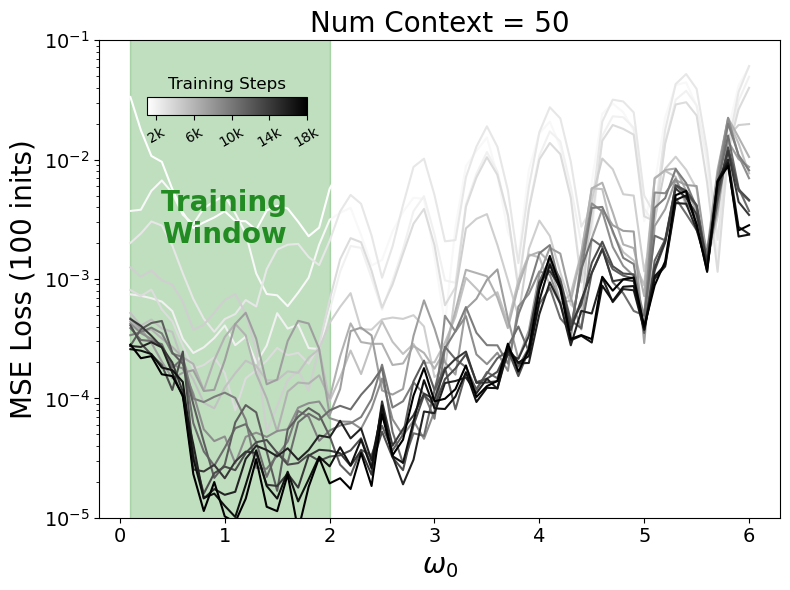

In [117]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

n_ctx = 50
lines = []
for i,ck in enumerate(iter_ckpts):
    line, = plt.plot(w0s,losses[ck][:,n_ctx-1],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Num Context = {n_ctx}",fontsize=20)
plt.fill_betweenx([0,1],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-5,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss ({num_per} inits)",fontsize=20)
plt.text(1,2e-3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.19, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.pdf")
plt.show()

def update(frame):
    for i,ck in enumerate(iter_ckpts):
        lines[i].set_ydata(losses[ck][:,frame])
    ax.set_title(f"Num Context = {frame+1}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=losses[iter_ckpts[-1]].shape[1], interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_stepsOverlay_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/3239936146.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


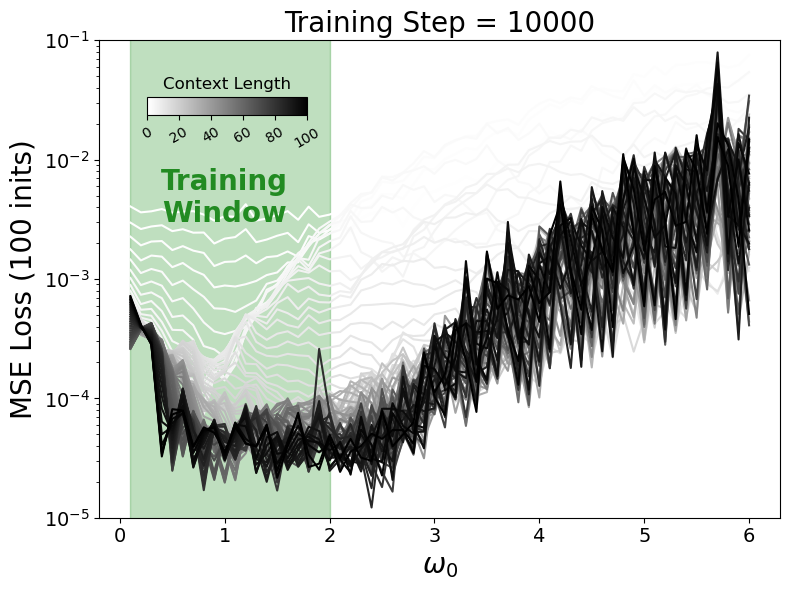

In [118]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(seq_len-2)) for i in range(seq_len-1)]

train_step = 10000
lines = []
for i in range(seq_len-1):
    line, = plt.plot(w0s,losses[train_step][:,i],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Training Step = {train_step}",fontsize=20)
plt.fill_betweenx([0,1],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-5,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss ({num_per} inits)",fontsize=20)
plt.text(1,3e-3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.19, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.png")
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.pdf")
plt.show()

def update(frame):
    for i in range(seq_len-1):
        lines[i].set_ydata(losses[iter_ckpts[frame]][:,i])
    ax.set_title(f"Training Step = {iter_ckpts[frame]}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(iter_ckpts), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_ctxOverlay_stepAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=2))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/3178151206.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


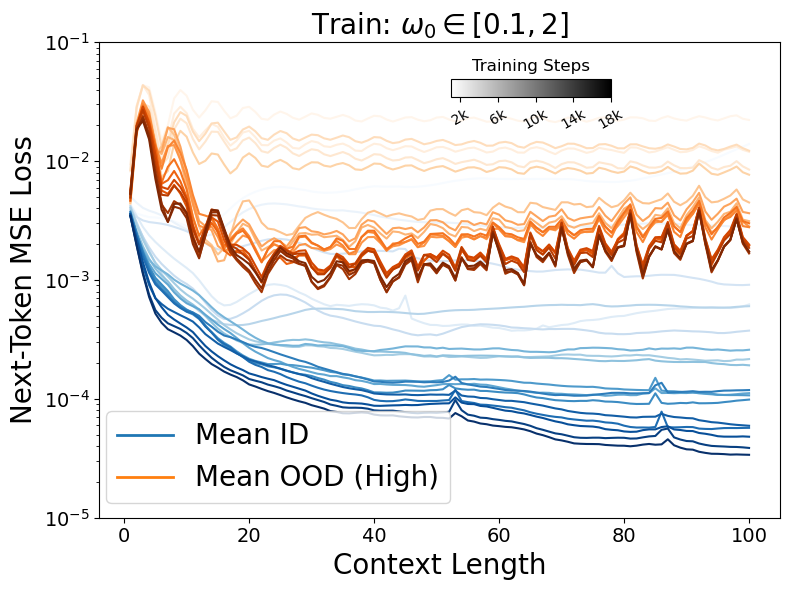

In [119]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_oranges = [cmap_oranges(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_greens = [plt.get_cmap("Greens")(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]

fig = plt.figure(figsize=(8,6))

for i,ni in enumerate(iter_ckpts):
    d_id = losses[ni][mask_id].mean(axis=0)
    d_ood = losses[ni][mask_ood].mean(axis=0)
    n_ctx = np.arange(1,losses[ni].shape[1]+1)
    plt.plot(n_ctx,d_id,color=colors_blues[i])
    plt.plot(n_ctx,d_ood,color=colors_oranges[i])
plt.yscale('log')
plt.ylim([1e-5,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Context Length",fontsize=20)
plt.ylabel("Next-Token MSE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (High)",lw=2,color="C1")
plt.legend(handles=[l1,l2],loc=(0.01,0.03),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.57, 0.83, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.pdf")

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/4184417460.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


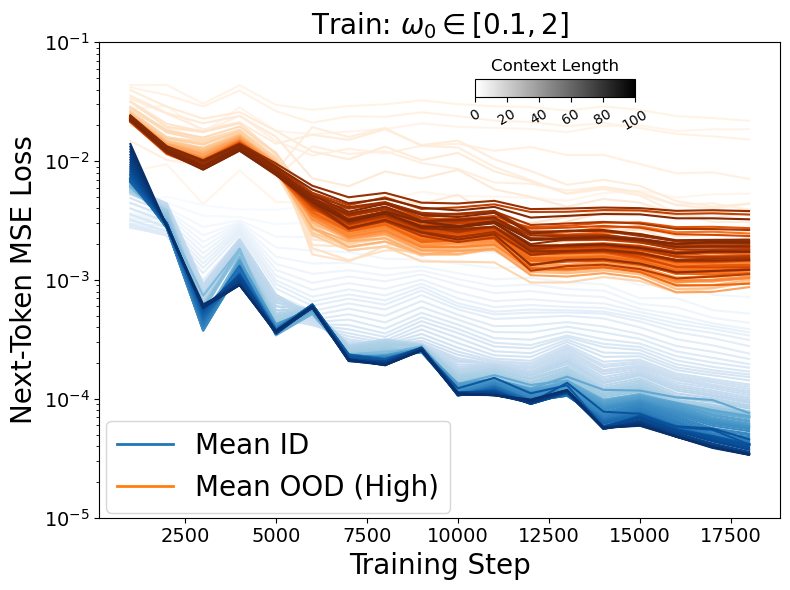

In [120]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_oranges = [cmap_oranges(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_greens = [plt.get_cmap("Greens")(i / (seq_len - 2)) for i in range(seq_len-1)]

fig = plt.figure(figsize=(8,6))

for nc in range(seq_len-1):
    l_id = []
    l_ood = []
    for nsteps in iter_ckpts:
        l_id.append(losses[nsteps][mask_id].mean(axis=0)[nc])
        l_ood.append(losses[nsteps][mask_ood].mean(axis=0)[nc])
    plt.plot(iter_ckpts,l_id,color=colors_blues[nc])
    plt.plot(iter_ckpts,l_ood,color=colors_oranges[nc])

plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([1e-5,0.1])
plt.xlabel("Training Step",fontsize=20)
plt.ylabel("Next-Token MSE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (High)",lw=2,color="C1")
plt.legend(handles=[l1,l2],loc=(0.01,0.01),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.6, 0.83, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(0,seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.pdf")

In [121]:
for wsel in w0s:
    for ckpt_sel in [1000,5000,10000,15000]:
        iw = list(w0s).index(wsel)
        fig = plt.figure(figsize=(8,6))
        
        d = losses[ckpt_sel][iw]
        n_ctx = np.arange(1,d.shape[0]+1)
        plt.plot(n_ctx,d,lw=2)
        
        plt.ylim([1e-5,0.1])
        plt.yscale('log')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Context Length",fontsize=20)
        plt.ylabel("Next-Token BCE Loss",fontsize=20)
        plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
        
        ymax = plt.gca().get_ylim()[1]
        plt.text(20,0.5*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
                 verticalalignment='center',horizontalalignment='center')


        def f_fit(x,b,a,phi):
            return b + a*np.cos(2*wsel*x+phi)

        popt, pcov = curve_fit(f_fit, (n_ctx[19:])*dt, d[19:])
        plt.plot(n_ctx[19:],f_fit(dt*n_ctx[19:],*popt),color='red',linestyle='--',lw=2)

        line = Line2D([],[],lw=2,color='red',linestyle='--',label=r'$B + A\cos(2\omega_0 t + \phi)$')
        plt.legend(handles=[line],loc='upper right',fontsize=20)
        
        plt.tight_layout()

        out_dir = f"{plot_dir}/losses_byCtx/w{wsel:.1f}/"
        os.makedirs(out_dir,exist_ok=True)
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.png")
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.pdf")
        plt.close()

In [122]:
wsel = w0s[0]
for ckpt_sel in iter_ckpts:
    iw = list(w0s).index(wsel)
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    d = losses[ckpt_sel][iw]
    n_ctx = np.arange(1,d.shape[0]+1)
    line, = plt.plot(n_ctx,d)

    plt.yscale('log')
    plt.ylim([losses[ckpt_sel].min(),2*losses[ckpt_sel].max()])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Context Length",fontsize=20)
    plt.ylabel("Next-Token BCE Loss",fontsize=20)
    plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
    
    ymax = plt.gca().get_ylim()[1]
    text = plt.text(50,0.4*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
             verticalalignment='center',horizontalalignment='center')
    
    plt.tight_layout()

    out_dir = f"{plot_dir}/losses_byCtx/animate_varyW0/"
    os.makedirs(out_dir,exist_ok=True)
    
    def update(frame):
        wsel = w0s[frame]
        d = losses[ckpt_sel][frame]
        line.set_ydata(d)
        #ax.set_ylim([0,d.max()])
        text.set_text(f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$")
        #text.set_position((50,0.9*d.max()))
        return [line]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w0s), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{out_dir}/animatedW0_step{ckpt_sel}.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

### NTP after N periods (varying context length by freq)

In [123]:
num_per = 100
inpt = []
target = []

w0s = np.array([0.1] + list(np.arange(0.5,6.5,0.5)))
seq_len = int(1.5*np.max((2*np.pi/w0s)/0.1)) + 10
losses = {i_it:[] for i_it in iter_ckpts}

for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
    with torch.no_grad():
        for i_it in tqdm(iter_ckpts):
            iter_models[i_it] = iter_models[i_it].to(device)
            pred = iter_models[i_it](i.to(device)).to('cpu')
            losses[i_it].append(torch.sum((pred-t)**2,dim=-1).mean(dim=0).numpy().reshape(1,-1))
            iter_models[i_it] = iter_models[i_it].to('cpu')
            
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)
losses = {i_it:np.concatenate(losses[i_it],axis=0) for i_it in iter_ckpts}

100%|█████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.50it/s]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/414962962.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


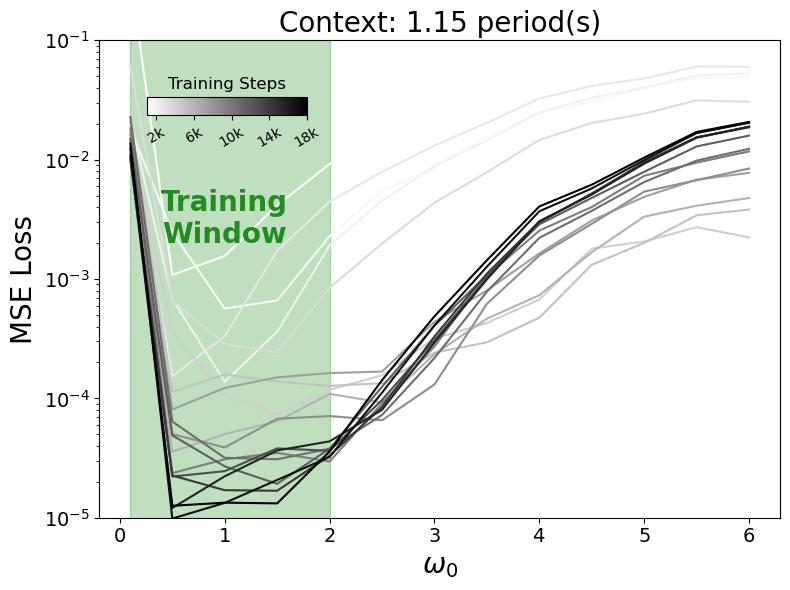

In [124]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

lines = []
Tfrac = 1.15
fractions = np.linspace(0.1,1.5,100)
for i,ck in enumerate(iter_ckpts):
    sel_losses = []
    for iw,w0 in enumerate(w0s):
        T = int(np.ceil(Tfrac*(2*np.pi/w0)/0.1))
        sel_loss = losses[ck][iw,T]
        sel_losses.append(sel_loss)
    line, = plt.plot(w0s,sel_losses,color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Context: {Tfrac} period(s)",fontsize=20)
plt.fill_betweenx([0,1],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-5,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss",fontsize=20)
plt.text(1,2e-3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.19, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_periods{Tfrac}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_periods{Tfrac}.pdf")
plt.show()

def update(frame):
    Tfrac = fractions[frame]
    for i,ck in enumerate(iter_ckpts):
        ydata = []
        for iw,w in enumerate(w0s):
            Tstep = int(np.ceil(Tfrac*(2*np.pi/w0)/0.1))
            ydata.append(losses[ck][iw,Tstep])
        lines[i].set_ydata(ydata)
    ax.set_title(f"Context: {fractions[frame]:.2f} periods",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(fractions), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_periods_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

# Extrapolate $\omega_0$ high to low

In [125]:
model = "mse_continuousW0Beta_wHi_beta0"
date = "12Feb25_1205"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir, version=date)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']

plot_dir = f"plots/{model}_{date}"
os.makedirs(plot_dir,exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
mask_id = (w0s>=2.0)&(w0s<=4.0)
mask_ood_hi = (w0s>4.0)
mask_ood_lo = (w0s<2.0)

In [126]:
seq_len = 101
num_per = 100
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

losses = {}
with torch.no_grad():
    for i_it in tqdm(iter_ckpts):
        iter_models[i_it] = iter_models[i_it].to(device)
        pred = iter_models[i_it](inpt.to(device)).to('cpu')
        losses[i_it] = torch.sum((pred-target)**2,dim=-1).view(len(w0s),num_per,seq_len-1).mean(dim=1).numpy()
        iter_models[i_it] = iter_models[i_it].to('cpu')

100%|█████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.34it/s]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/2907336549.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


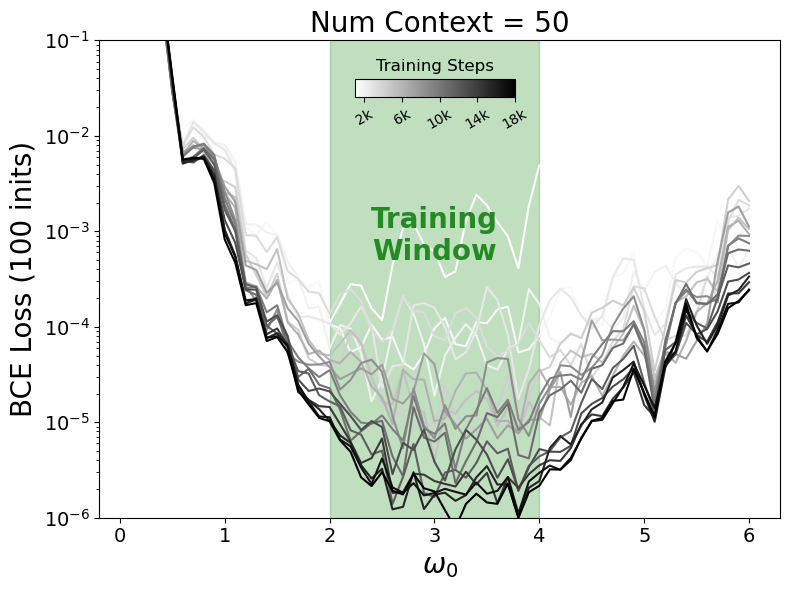

In [127]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

n_ctx = 50
lines = []
for i,ck in enumerate(iter_ckpts):
    line, = plt.plot(w0s,losses[ck][:,n_ctx-1],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Num Context = {n_ctx}",fontsize=20)
plt.fill_betweenx([0,1],[2,2],[4,4],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-6,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
plt.text(3,5e-4,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.45, 0.83, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.pdf")
plt.show()

def update(frame):
    for i,ck in enumerate(iter_ckpts):
        lines[i].set_ydata(losses[ck][:,frame])
    ax.set_title(f"Num Context = {frame+1}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=losses[iter_ckpts[-1]].shape[1], interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_stepsOverlay_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/3957546841.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


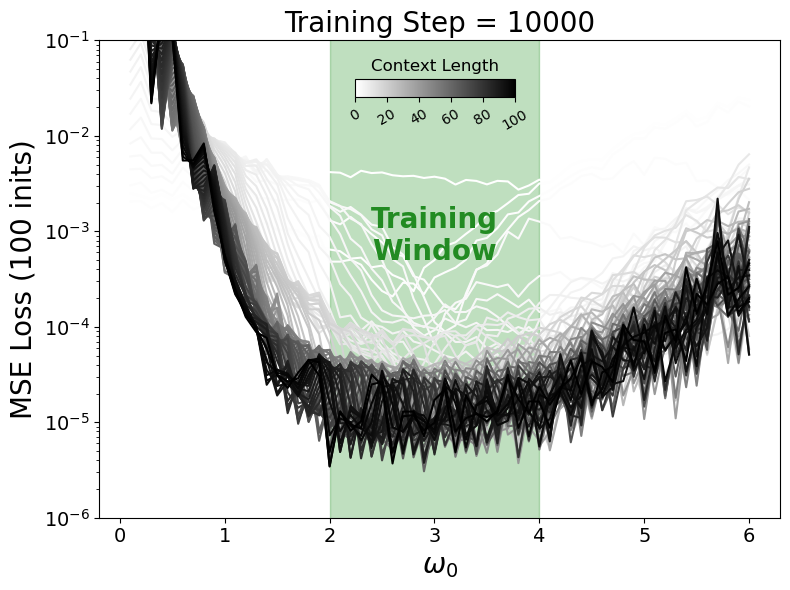

In [128]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(seq_len-2)) for i in range(seq_len-1)]

train_step = 10000
lines = []
for i in range(seq_len-1):
    line, = plt.plot(w0s,losses[train_step][:,i],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Training Step = {train_step}",fontsize=20)
plt.fill_betweenx([0,1],[2,2],[4,4],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-6,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss ({num_per} inits)",fontsize=20)
plt.text(3,5e-4,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.45, 0.83, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.png")
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.pdf")
plt.show()

def update(frame):
    for i in range(seq_len-1):
        lines[i].set_ydata(losses[iter_ckpts[frame]][:,i])
    ax.set_title(f"Training Step = {iter_ckpts[frame]}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(iter_ckpts), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_ctxOverlay_stepAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=2))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/889272774.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


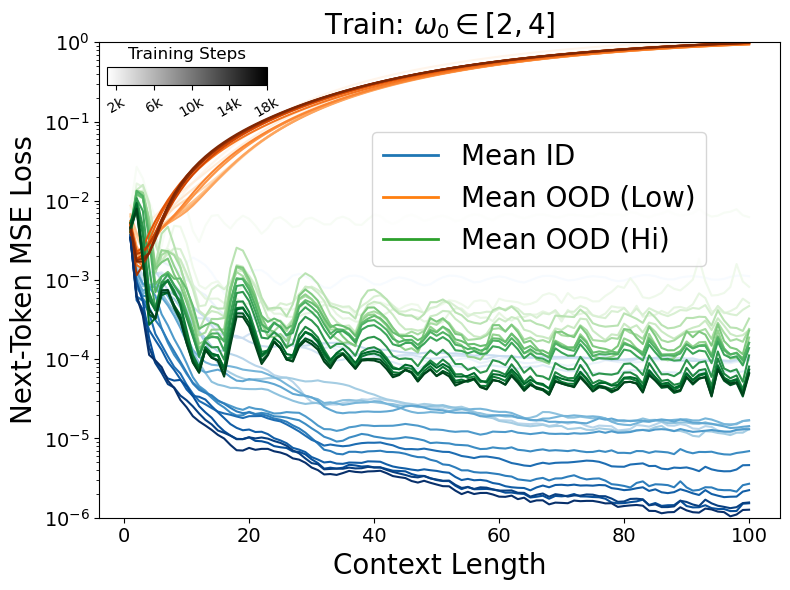

In [129]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_oranges = [cmap_oranges(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_greens = [plt.get_cmap("Greens")(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]

fig = plt.figure(figsize=(8,6))

for i,ni in enumerate(iter_ckpts):
    d_id = losses[ni][mask_id].mean(axis=0)
    d_ood_lo = losses[ni][mask_ood_lo].mean(axis=0)
    d_ood_hi = losses[ni][mask_ood_hi].mean(axis=0)
    n_ctx = np.arange(1,losses[ni].shape[1]+1)
    plt.plot(n_ctx,d_id,color=colors_blues[i])
    plt.plot(n_ctx,d_ood_lo,color=colors_oranges[i])
    plt.plot(n_ctx,d_ood_hi,color=colors_greens[i])
plt.yscale('log')
plt.ylim([1e-6,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Context Length",fontsize=20)
plt.ylabel("Next-Token MSE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (Low)",lw=2,color="C1")
l3 = Line2D([],[],label="Mean OOD (Hi)",lw=2,color="C2")
plt.legend(handles=[l1,l2,l3],loc=(0.4,0.53),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.14, 0.85, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.pdf")

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/4264420277.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


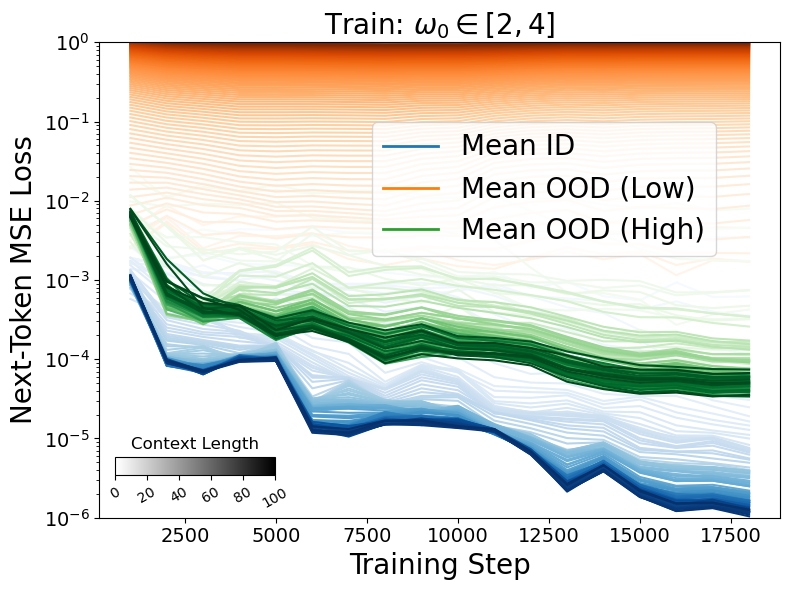

In [130]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_oranges = [cmap_oranges(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_greens = [plt.get_cmap("Greens")(i / (seq_len - 2)) for i in range(seq_len-1)]

fig = plt.figure(figsize=(8,6))

for nc in range(seq_len-1):
    l_id = []
    l_ood_lo = []
    l_ood_hi = []
    for nsteps in iter_ckpts:
        l_id.append(losses[nsteps][mask_id].mean(axis=0)[nc])
        l_ood_lo.append(losses[nsteps][mask_ood_lo].mean(axis=0)[nc])
        l_ood_hi.append(losses[nsteps][mask_ood_hi].mean(axis=0)[nc])
    plt.plot(iter_ckpts,l_id,color=colors_blues[nc])
    plt.plot(iter_ckpts,l_ood_lo,color=colors_oranges[nc])
    plt.plot(iter_ckpts,l_ood_hi,color=colors_greens[nc])

plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([1e-6,1])
plt.xlabel("Training Step",fontsize=20)
plt.ylabel("Next-Token MSE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (Low)",lw=2,color="C1")
l3 = Line2D([],[],label="Mean OOD (High)",lw=2,color="C2")
plt.legend(handles=[l1,l2,l3],loc=(0.4,0.55),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.15, 0.2, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(0,seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.pdf")

In [131]:
for wsel in w0s:
    for ckpt_sel in [1000,5000,10000,15000]:
        iw = list(w0s).index(wsel)
        fig = plt.figure(figsize=(8,6))
        
        d = losses[ckpt_sel][iw]
        n_ctx = np.arange(1,d.shape[0]+1)
        plt.plot(n_ctx,d,lw=2)

        plt.yscale('log')
        plt.ylim([1e-5,1])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Context Length",fontsize=20)
        plt.ylabel("Next-Token MSE Loss",fontsize=20)
        plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
        
        ymax = plt.gca().get_ylim()[1]
        plt.text(20,0.4*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
                 verticalalignment='center',horizontalalignment='center')


        def f_fit(x,b,a,phi):
            return b + a*np.cos(2*wsel*x+phi)

        popt, pcov = curve_fit(f_fit, (n_ctx[19:])*dt, d[19:])
        plt.plot(n_ctx[19:],f_fit(dt*n_ctx[19:],*popt),color='red',linestyle='--',lw=2)

        line = Line2D([],[],lw=2,color='red',linestyle='--',label=r'$B + A\cos(2\omega_0 t + \phi)$')
        plt.legend(handles=[line],loc='upper right',fontsize=20)
        
        plt.tight_layout()

        out_dir = f"{plot_dir}/losses_byCtx/w{wsel:.1f}/"
        os.makedirs(out_dir,exist_ok=True)
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.png")
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.pdf")
        plt.close()

In [132]:
wsel = w0s[0]
for ckpt_sel in iter_ckpts:
    iw = list(w0s).index(wsel)
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    d = losses[ckpt_sel][iw]
    n_ctx = np.arange(1,d.shape[0]+1)
    line, = plt.plot(n_ctx,d)

    plt.yscale('log')
    plt.ylim([1e-5,1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Context Length",fontsize=20)
    plt.ylabel("Next-Token MSE Loss",fontsize=20)
    plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
    
    ymax = plt.gca().get_ylim()[1]
    text = plt.text(50,0.4*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
             verticalalignment='center',horizontalalignment='center')
    
    plt.tight_layout()

    out_dir = f"{plot_dir}/losses_byCtx/animate_varyW0/"
    os.makedirs(out_dir,exist_ok=True)
    
    def update(frame):
        wsel = w0s[frame]
        d = losses[ckpt_sel][frame]
        line.set_ydata(d)
        #ax.set_ylim([0,d.max()])
        text.set_text(f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$")
        #text.set_position((50,0.9*d.max()))
        return [line]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w0s), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{out_dir}/animatedW0_step{ckpt_sel}.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

### NTP after N periods (varying context length by freq)

In [135]:
num_per = 100
inpt = []
target = []

w0s = np.array([0.1] + list(np.arange(0.5,6.5,0.5)))
seq_len = int(1.5*np.max((2*np.pi/w0s)/0.1)) + 10
losses = {i_it:[] for i_it in iter_ckpts}

for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
    with torch.no_grad():
        for i_it in tqdm(iter_ckpts):
            iter_models[i_it] = iter_models[i_it].to(device)
            pred = iter_models[i_it](i.to(device)).to('cpu')
            losses[i_it].append(torch.sum((pred-t)**2,dim=-1).mean(dim=0).numpy().reshape(1,-1))
            iter_models[i_it] = iter_models[i_it].to('cpu')
            
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)
losses = {i_it:np.concatenate(losses[i_it],axis=0) for i_it in iter_ckpts}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.47it/s]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/911724098.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


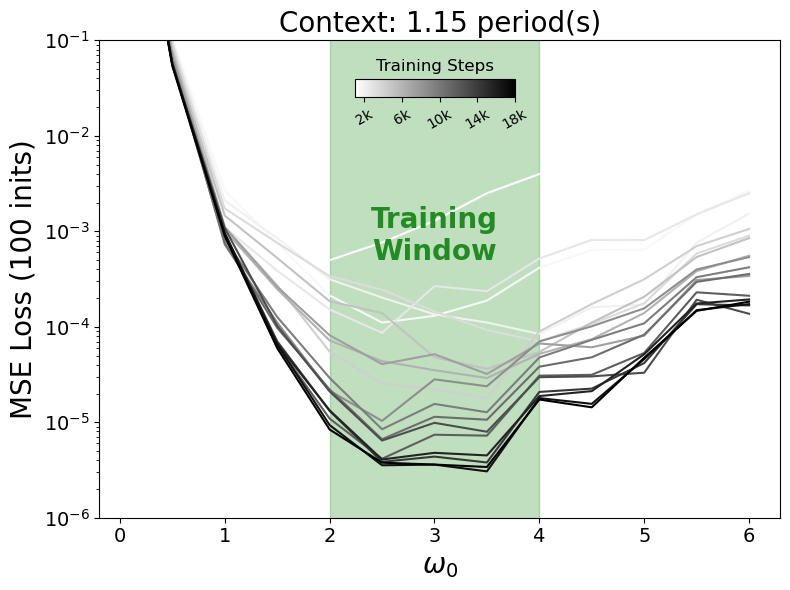

In [136]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

lines = []
Tfrac = 1.15
fractions = np.linspace(0.1,1.5,100)
for i,ck in enumerate(iter_ckpts):
    sel_losses = []
    for iw,w0 in enumerate(w0s):
        T = int(np.ceil(Tfrac*(2*np.pi/w0)/0.1))
        sel_loss = losses[ck][iw,T]
        sel_losses.append(sel_loss)
    line, = plt.plot(w0s,sel_losses,color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Context: {Tfrac} period(s)",fontsize=20)
plt.fill_betweenx([0,1],[2,2],[4,4],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-6,0.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss ({num_per} inits)",fontsize=20)
plt.text(3,5e-4,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.45, 0.83, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
ticks = iter_ckpts[1::4]
cbar_ax.set_xticks(ticks=ticks,labels=[f"{int(t/1000)}k" for t in ticks])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_periods{Tfrac}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_periods{Tfrac}.pdf")
plt.show()

def update(frame):
    Tfrac = fractions[frame]
    for i,ck in enumerate(iter_ckpts):
        ydata = []
        for iw,w in enumerate(w0s):
            Tstep = int(np.ceil(Tfrac*(2*np.pi/w0)/0.1))
            ydata.append(losses[ck][iw,Tstep])
        lines[i].set_ydata(ydata)
    ax.set_title(f"Context: {fractions[frame]:.2f} periods",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(fractions), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_periods_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

# Interpolate $\omega_0$

In [137]:
model = "mse_continuousW0Beta_wLoHi_beta0"
date = "12Feb25_1205"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir, version=date)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']
plot_dir = f"plots/{model}"
os.makedirs(plot_dir,exist_ok=True)

plot_dir = f"plots/{model}_{date}"
os.makedirs(plot_dir,exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
mask_id = ((w0s>=0.1)&(w0s<=2.0)) | ((w0s>=3.0)&(w0s<4.0))
mask_interp = (w0s>2.0)&(w0s<3.0)
mask_ood = w0s>4.0

In [138]:
num_per = 100
seq_len = 101
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

losses = {}
with torch.no_grad():
    for i_it in tqdm(iter_ckpts):
        iter_models[i_it] = iter_models[i_it].to(device)
        pred = iter_models[i_it](inpt.to(device)).to('cpu')
        losses[i_it] = torch.sum((pred-target)**2,dim=-1).view(len(w0s),num_per,seq_len-1).mean(dim=1).numpy()
        iter_models[i_it] = iter_models[i_it].to('cpu')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.10it/s]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/1006342912.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


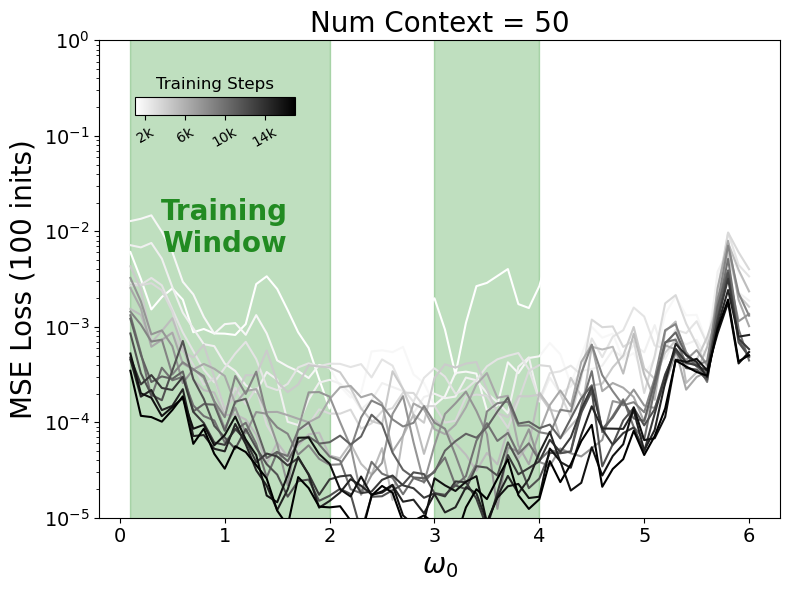

In [139]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

n_ctx = 50
lines = []
for i,ck in enumerate(iter_ckpts):
    line, = plt.plot(w0s,losses[ck][:,n_ctx-1],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Num Context = {n_ctx}",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.fill_betweenx([0,25],[3,3],[4,4],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-5,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss ({num_per} inits)",fontsize=20)
#p = Patch(color='green',alpha=0.25,label="Training \nWindow")
#plt.legend(handles=[p],loc='upper right',fontsize=18)
plt.text(1,6e-3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.175, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.pdf")
plt.show()

def update(frame):
    for i,ck in enumerate(iter_ckpts):
        lines[i].set_ydata(losses[ck][:,frame])
    ax.set_title(f"Num Context = {frame+1}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=losses[iter_ckpts[-1]].shape[1], interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_stepsOverlay_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/1833038242.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


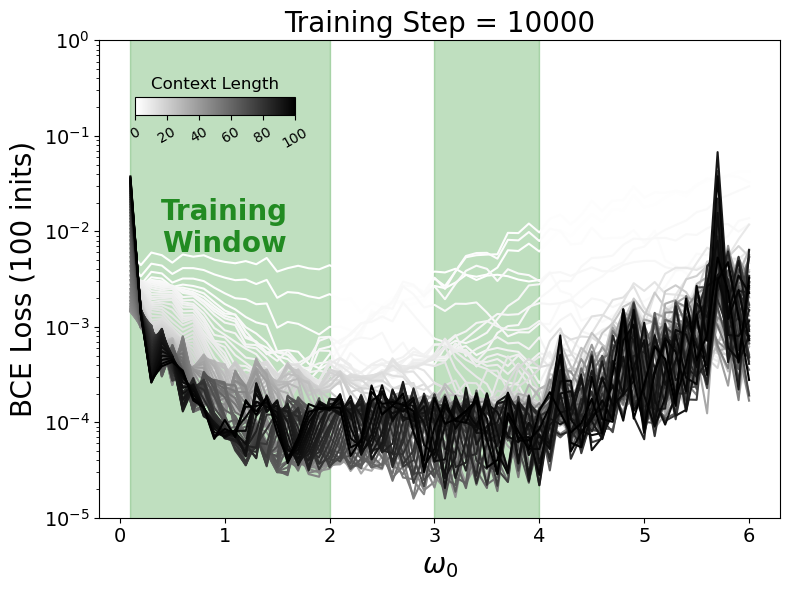

In [140]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(seq_len-2)) for i in range(seq_len-1)]

train_step = 10000
lines = []
for i in range(seq_len-1):
    line, = plt.plot(w0s,losses[train_step][:,i],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Training Step = {train_step}",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.fill_betweenx([0,25],[3,3],[4,4],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-5,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
#p = Patch(color='green',alpha=0.25,label="Training \nWindow")
#plt.legend(handles=[p],loc='upper right',fontsize=18)
plt.text(1,6e-3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.175, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.png")
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.pdf")
plt.show()

def update(frame):
    for i in range(seq_len-1):
        lines[i].set_ydata(losses[iter_ckpts[frame]][:,i])
    ax.set_title(f"Training Step = {iter_ckpts[frame]}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(iter_ckpts), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_ctxOverlay_stepAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=2))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/595575986.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


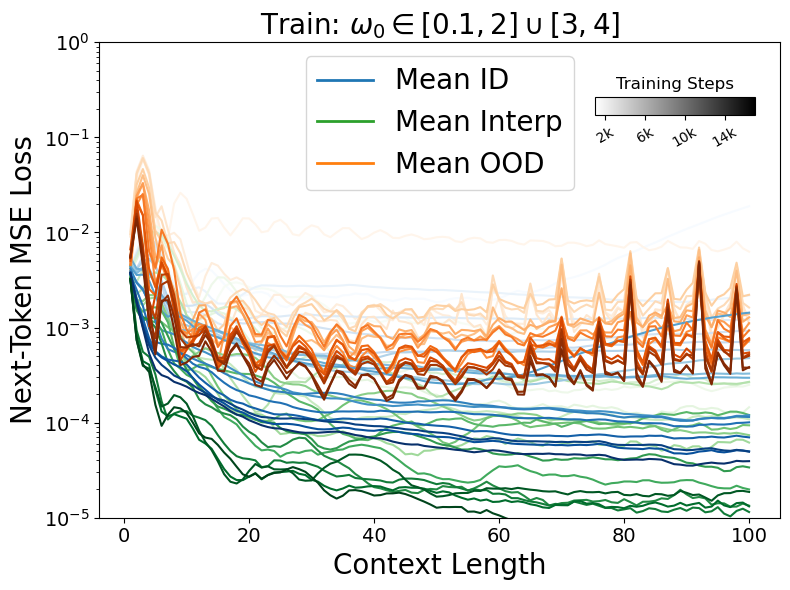

In [141]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_oranges = [cmap_oranges(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_greens = [plt.get_cmap("Greens")(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]

fig = plt.figure(figsize=(8,6))

for i,ni in enumerate(iter_ckpts):
    d_id = losses[ni][mask_id].mean(axis=0)
    d_interp = losses[ni][mask_interp].mean(axis=0)
    d_ood = losses[ni][mask_ood].mean(axis=0)
    n_ctx = np.arange(1,losses[ni].shape[1]+1)
    plt.plot(n_ctx,d_id,color=colors_blues[i])
    plt.plot(n_ctx,d_ood,color=colors_oranges[i])
    plt.plot(n_ctx,d_interp,color=colors_greens[i])
plt.yscale('log')
plt.ylim([1e-5,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Context Length",fontsize=20)
plt.ylabel("Next-Token MSE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD",lw=2,color="C1")
l3 = Line2D([],[],label="Mean Interp",lw=2,color="C2")
plt.legend(handles=[l1,l3,l2],loc='upper center',fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.75, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.pdf")

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/710957611.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


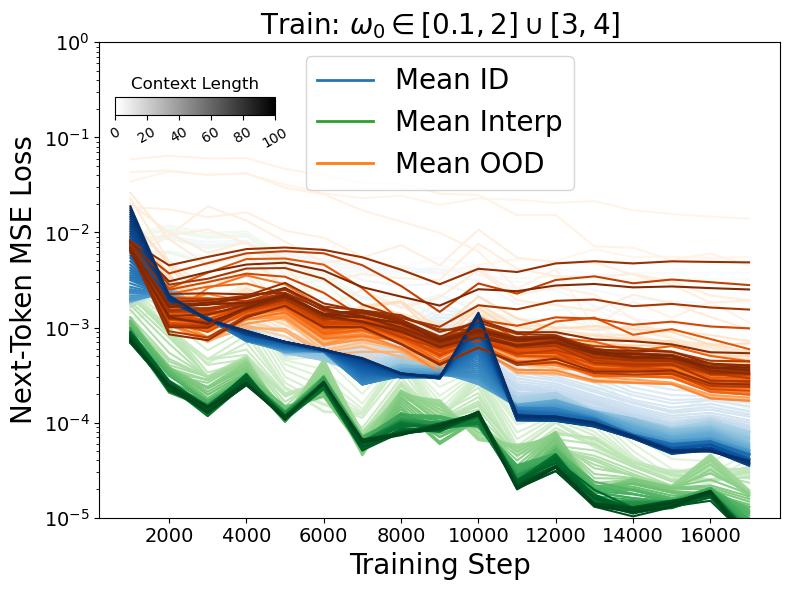

In [142]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_oranges = [cmap_oranges(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_greens = [plt.get_cmap("Greens")(i / (seq_len - 2)) for i in range(seq_len-1)]

fig = plt.figure(figsize=(8,6))

for nc in range(seq_len-1):
    l_id = []
    l_ood = []
    l_interp = []
    for nsteps in iter_ckpts:
        l_id.append(losses[nsteps][mask_id].mean(axis=0)[nc])
        l_ood.append(losses[nsteps][mask_ood].mean(axis=0)[nc])
        l_interp.append(losses[nsteps][mask_interp].mean(axis=0)[nc])
    plt.plot(iter_ckpts,l_id,color=colors_blues[nc])
    plt.plot(iter_ckpts,l_ood,color=colors_oranges[nc])
    plt.plot(iter_ckpts,l_interp,color=colors_greens[nc])

plt.yscale('log')
plt.ylim([1e-5,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Training Step",fontsize=20)
plt.ylabel("Next-Token MSE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD",lw=2,color="C1")
l3 = Line2D([],[],label="Mean Interp",lw=2,color="C2")
plt.legend(handles=[l1,l3,l2],loc='upper center',fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.15, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(0,seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.pdf")

In [143]:
for wsel in w0s:
    for ckpt_sel in [1000,5000,10000,15000]:
        iw = list(w0s).index(wsel)
        fig = plt.figure(figsize=(8,6))
        
        d = losses[ckpt_sel][iw]
        n_ctx = np.arange(1,d.shape[0]+1)
        plt.plot(n_ctx,d,lw=2)

        plt.yscale('log')
        plt.ylim([1e-5,1])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Context Length",fontsize=20)
        plt.ylabel("Next-Token MSE Loss",fontsize=20)
        plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
        
        ymax = plt.gca().get_ylim()[1]
        plt.text(20,0.3*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
                 verticalalignment='center',horizontalalignment='center')

        def f_fit(x,b,a,phi):
            return b + a*np.cos(2*wsel*x+phi)

        popt, pcov = curve_fit(f_fit, (n_ctx[19:])*dt, d[19:])
        plt.plot(n_ctx[19:],f_fit(dt*n_ctx[19:],*popt),color='red',linestyle='--',lw=2)
        line = Line2D([],[],lw=2,color='red',linestyle='--',label=r'$B + A\cos(2\omega_0 t + \phi)$')
        plt.legend(handles=[line],loc='upper right',fontsize=20)
        
        plt.tight_layout()

        out_dir = f"{plot_dir}/losses_byCtx/w{wsel:.1f}/"
        os.makedirs(out_dir,exist_ok=True)
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.png")
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.pdf")
        plt.close()

In [144]:
wsel = w0s[0]
for ckpt_sel in iter_ckpts:
    iw = list(w0s).index(wsel)
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    d = losses[ckpt_sel][iw]
    n_ctx = np.arange(1,d.shape[0]+1)
    line, = plt.plot(n_ctx,d)

    plt.yscale('log')
    plt.ylim([1e-5,1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Context Length",fontsize=20)
    plt.ylabel("Next-Token MSE Loss",fontsize=20)
    plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
    
    ymax = plt.gca().get_ylim()[1]
    text = plt.text(50,0.3*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
             verticalalignment='center',horizontalalignment='center')
    
    plt.tight_layout()

    out_dir = f"{plot_dir}/losses_byCtx/animate_varyW0/"
    os.makedirs(out_dir,exist_ok=True)
    
    def update(frame):
        wsel = w0s[frame]
        d = losses[ckpt_sel][frame]
        line.set_ydata(d)
        #ax.set_ylim([0,d.max()])
        text.set_text(f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$")
        #text.set_position((50,0.9*d.max()))
        return [line]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w0s), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{out_dir}/animatedW0_step{ckpt_sel}.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

### NTP after N periods (varying context length by freq)

In [145]:
num_per = 100
inpt = []
target = []

w0s = np.array([0.1] + list(np.arange(0.5,6.5,0.5)))
seq_len = int(1.5*np.max((2*np.pi/w0s)/0.1)) + 10
losses = {i_it:[] for i_it in iter_ckpts}

for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
    with torch.no_grad():
        for i_it in tqdm(iter_ckpts):
            iter_models[i_it] = iter_models[i_it].to(device)
            pred = iter_models[i_it](i.to(device)).to('cpu')
            losses[i_it].append(torch.sum((pred-t)**2,dim=-1).mean(dim=0).numpy().reshape(1,-1))
            iter_models[i_it] = iter_models[i_it].to('cpu')
            
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)
losses = {i_it:np.concatenate(losses[i_it],axis=0) for i_it in iter_ckpts}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_61885/1082612328.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


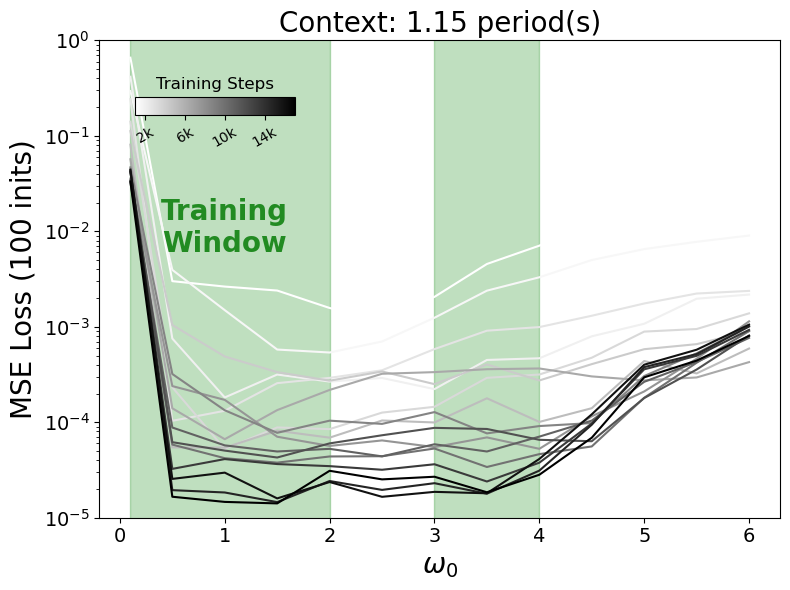

In [146]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

lines = []
Tfrac = 1.15
fractions = np.linspace(0.1,1.5,100)
for i,ck in enumerate(iter_ckpts):
    sel_losses = []
    for iw,w0 in enumerate(w0s):
        T = int(np.ceil(Tfrac*(2*np.pi/w0)/0.1))
        sel_loss = losses[ck][iw,T]
        sel_losses.append(sel_loss)
    line, = plt.plot(w0s,sel_losses,color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Context: {Tfrac} period(s)",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.fill_betweenx([0,25],[3,3],[4,4],color='green',alpha=0.25,zorder=0)
plt.yscale('log')
plt.ylim([1e-5,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"MSE Loss ({num_per} inits)",fontsize=20)
plt.text(1,6e-3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.175, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_periods{Tfrac}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_periods{Tfrac}.pdf")
plt.show()

def update(frame):
    Tfrac = fractions[frame]
    for i,ck in enumerate(iter_ckpts):
        ydata = []
        for iw,w in enumerate(w0s):
            Tstep = int(np.ceil(Tfrac*(2*np.pi/w0)/0.1))
            ydata.append(losses[ck][iw,Tstep])
        lines[i].set_ydata(ydata)
    ax.set_title(f"Context: {fractions[frame]:.2f} periods",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(fractions), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_periods_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

# investigate further: low --> high extrapolation

(0.0, 2.0)

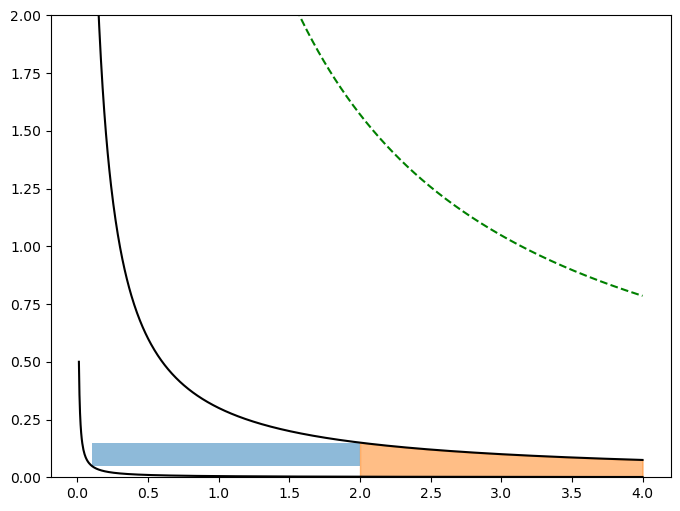

In [466]:
plt.figure(figsize=(8,6))
from matplotlib.patches import Rectangle

wtrain = np.linspace(0.1,2.0,100)
wtest = np.linspace(2,4,100)
dt_train = np.linspace(0.05,0.15,100)
wall = np.linspace(0.01,4,1000)

plt.fill_between(wtrain,dt_train[-1],dt_train[0],alpha=0.5)
#ylo = wtest*dt_train[0]
#yhi = wtest*dt_train[-1]
#plt.fill_between(wtrain,yhi/wtrain,ylo/wtrain,color="C1",alpha=0.5)
plt.plot(wall,wtrain[0]*dt_train[0]/wall,color='k')
#plt.plot(wall,wtrain[0]*dt_train[-1]/wall,color='k')
#plt.plot(wall,wtrain[-1]*dt_train[0]/wall,color='k')
plt.plot(wall,wtrain[-1]*dt_train[-1]/wall,color='k')
plt.plot(wall,(2*np.pi/wall)/2,color='green',linestyle='--')

plt.fill_between(wtest,wtrain[-1]*dt_train[-1]/wtest,wtrain[0]*dt_train[0]/wtest,color='C1',alpha=0.5)
plt.ylim([0,2])
#plt.xlim([0,4])
#T = 2*np.pi/w0
#for N in range(2,41):
#    plt.plot(w0,T/N)
#plt.yscale('log')

In [147]:
model = "mse_continuousW0Beta_wLo_beta0"
date = "12Feb25_1205"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir, version=date)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']

plot_dir = f"plots/{model}_{date}"
os.makedirs(plot_dir,exist_ok=True)
os.makedirs(f"{plot_dir}/waveforms/",exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
mask_id = (w0s<=2.0)
mask_ood = (w0s>2.0)

In [148]:
num_per = 1
inpt = []
target = []
x0 = 0
v0 = 1
seq_len_test = 200
dtfrac_w1 = dt/(2*np.pi/1.0)
for w0 in w0s:
    T = 2*np.pi/w0
    dt_sel = dtfrac_w1*T
    dset = DampedSHODatasetV2(beta=0,w0=w0,x0=x0,v0=v0,dt=dt,seq_len=seq_len_test)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

test_i = inpt.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
test_o = target.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

with torch.no_grad():
    preds = iter_models[iter_ckpts[-1]](inpt)
    losses = torch.sum((preds-target)**2,dim=-1).numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
    preds = preds.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

In [149]:
for iw,wsel in enumerate(w0s):

    i = test_i[iw,0,:,0]
    t = test_o[iw,0,:,0]
    p = preds[iw,0,:,0]
    T = (2*np.pi/wsel)/dt
    time = np.arange(seq_len_test)
    
    fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True,height_ratios=[3,1])
    plt.sca(axes[0])
    plt.plot(time[:-1],i,label='True')
    plt.plot(time[1:],p,label="Pred (1 step)")
    plt.xlim([0,100])
    plt.title(rf"$\omega_0 = {wsel:.1f}$ (train $\omega_0 \in [0.1,2]$)",fontsize=20)
    plt.sca(axes[1])
    plt.plot(time[1:-1],(i[1:]-p[:-1])**2,color='k')
    plt.yscale('log')
    plt.ylim([1e-6,1e-1])
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/waveforms/waveform_w{wsel:.1f}.pdf")
    plt.close()

In [60]:
def get_mse(wsel,acc=2):
    iw = list(np.round(w0s,acc)).index(np.round(wsel,acc))
    i = test_i[iw,0,:,0]
    p = preds[iw,0,:,0]
    return (i[1:]-p[:-1])**2

## attn maps

In [150]:
num_per = 1
inpt = []
target = []
x0 = 0
v0 = 1
seq_len_test = 250
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,x0=x0,v0=v0,dt=dt,seq_len=seq_len_test)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

test_i = inpt.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
test_o = target.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

for wsel in [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for ckpt in iter_ckpts:
        #wsel = 5
        iw = list(np.round(w0s,1)).index(wsel)
        i = test_i[iw]
        t = test_o[iw]
        
        with torch.no_grad():
            att = iter_models[ckpt](torch.tensor(i),return_attn=True)
            att = [a.numpy() for a in att]
        
        p = preds[iw,0,:,0]
        T = (2*np.pi/wsel)/dt
        time = np.arange(seq_len_test)
        
        n_head = att[0].shape[1]
        n_lay = len(att)
        fig,axes = plt.subplots(n_lay,n_head,figsize=(6*n_head,6*n_lay))
        for i in range(n_lay):
            for j in range(n_head):
                if n_head == 1:
                    ax = axes[i]
                elif n_lay == 1:
                    ax = axes[j]
                else:
                    ax = axes[i,j]
                plt.sca(ax)
                im=ax.imshow(att[i][0,j,:int(np.ceil(2*T)),:int(np.ceil(2*T))],norm=LogNorm(vmin=1e-3,vmax=0.1))
                for k in range(1,2):
                    plt.axhline(int(k*T),lw=2,linestyle='--',color='red')
                    plt.axvline(int(k*T),lw=2,linestyle='--',color='red')
                plt.colorbar(im,ax=ax,fraction=0.046)
                plt.title(rf"L = {i+1}, H = {j+1}, $\omega_0 = {wsel:.1f}$")
        plt.tight_layout()
        
        outdir = f"{plot_dir}/attn_maps/w{wsel}/"
        os.makedirs(outdir,exist_ok=True)
        plt.savefig(f"{outdir}/maps_w{wsel}_iter{ckpt}.pdf")
        plt.close()

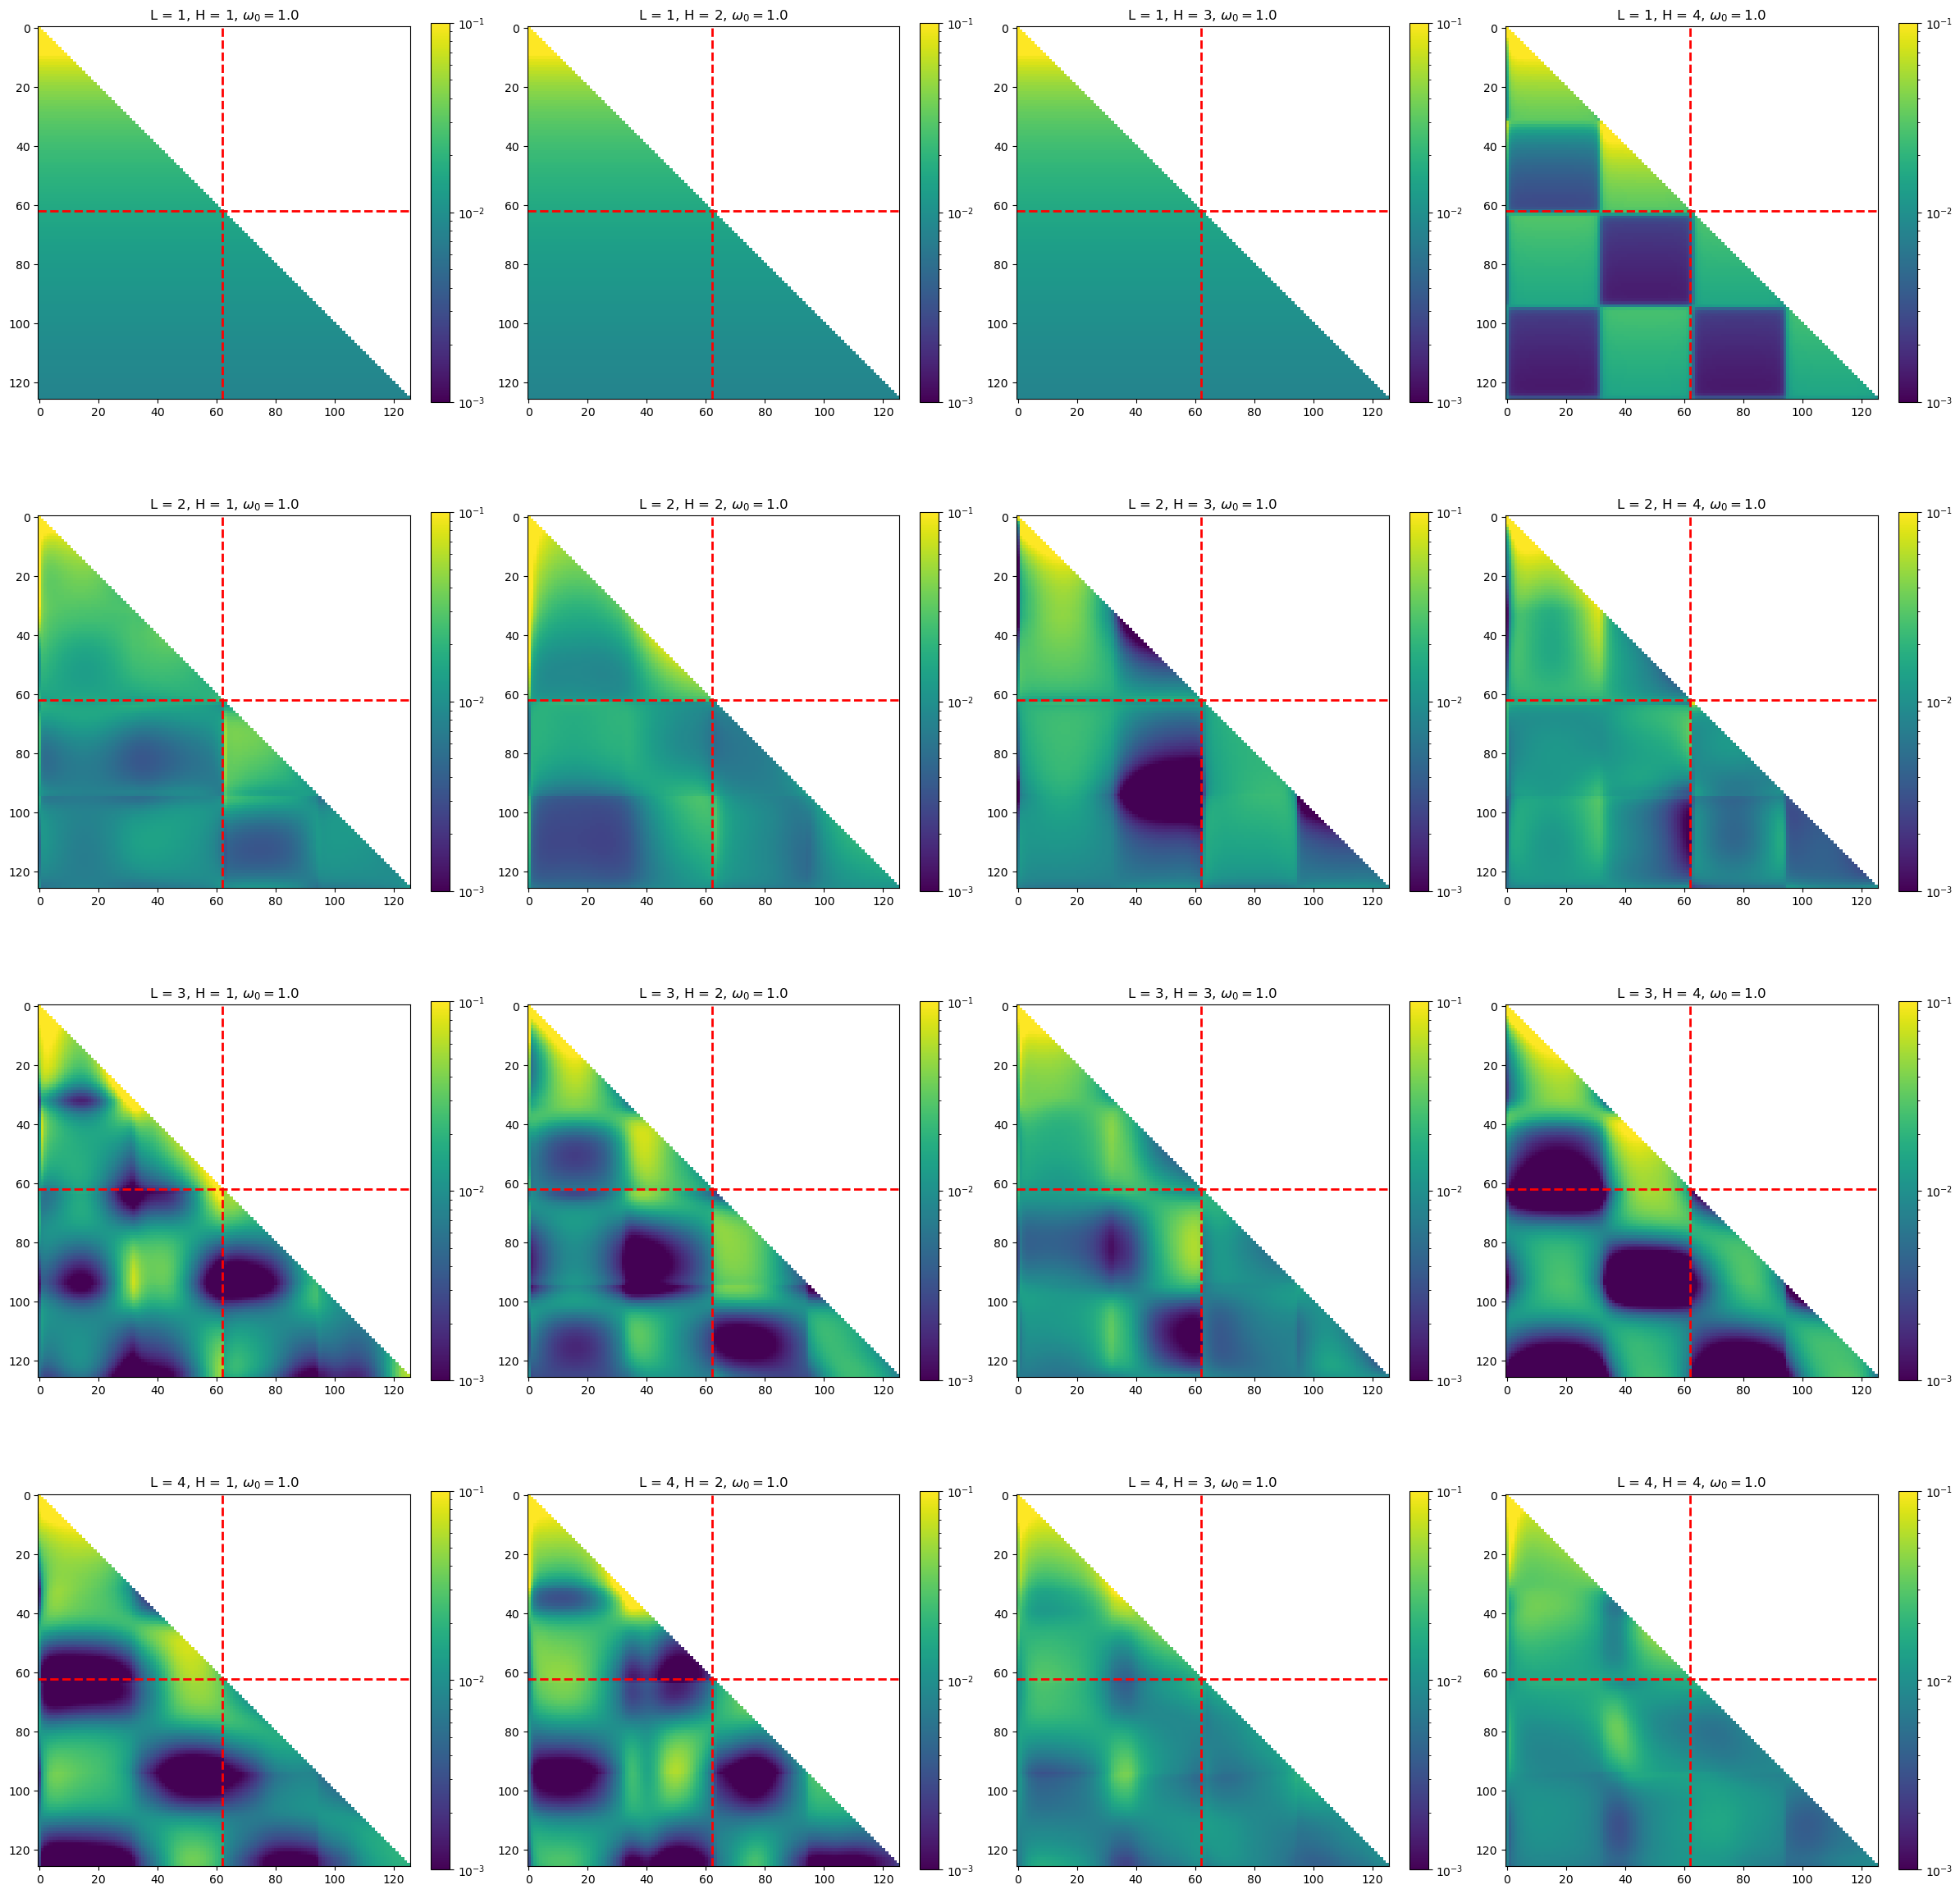

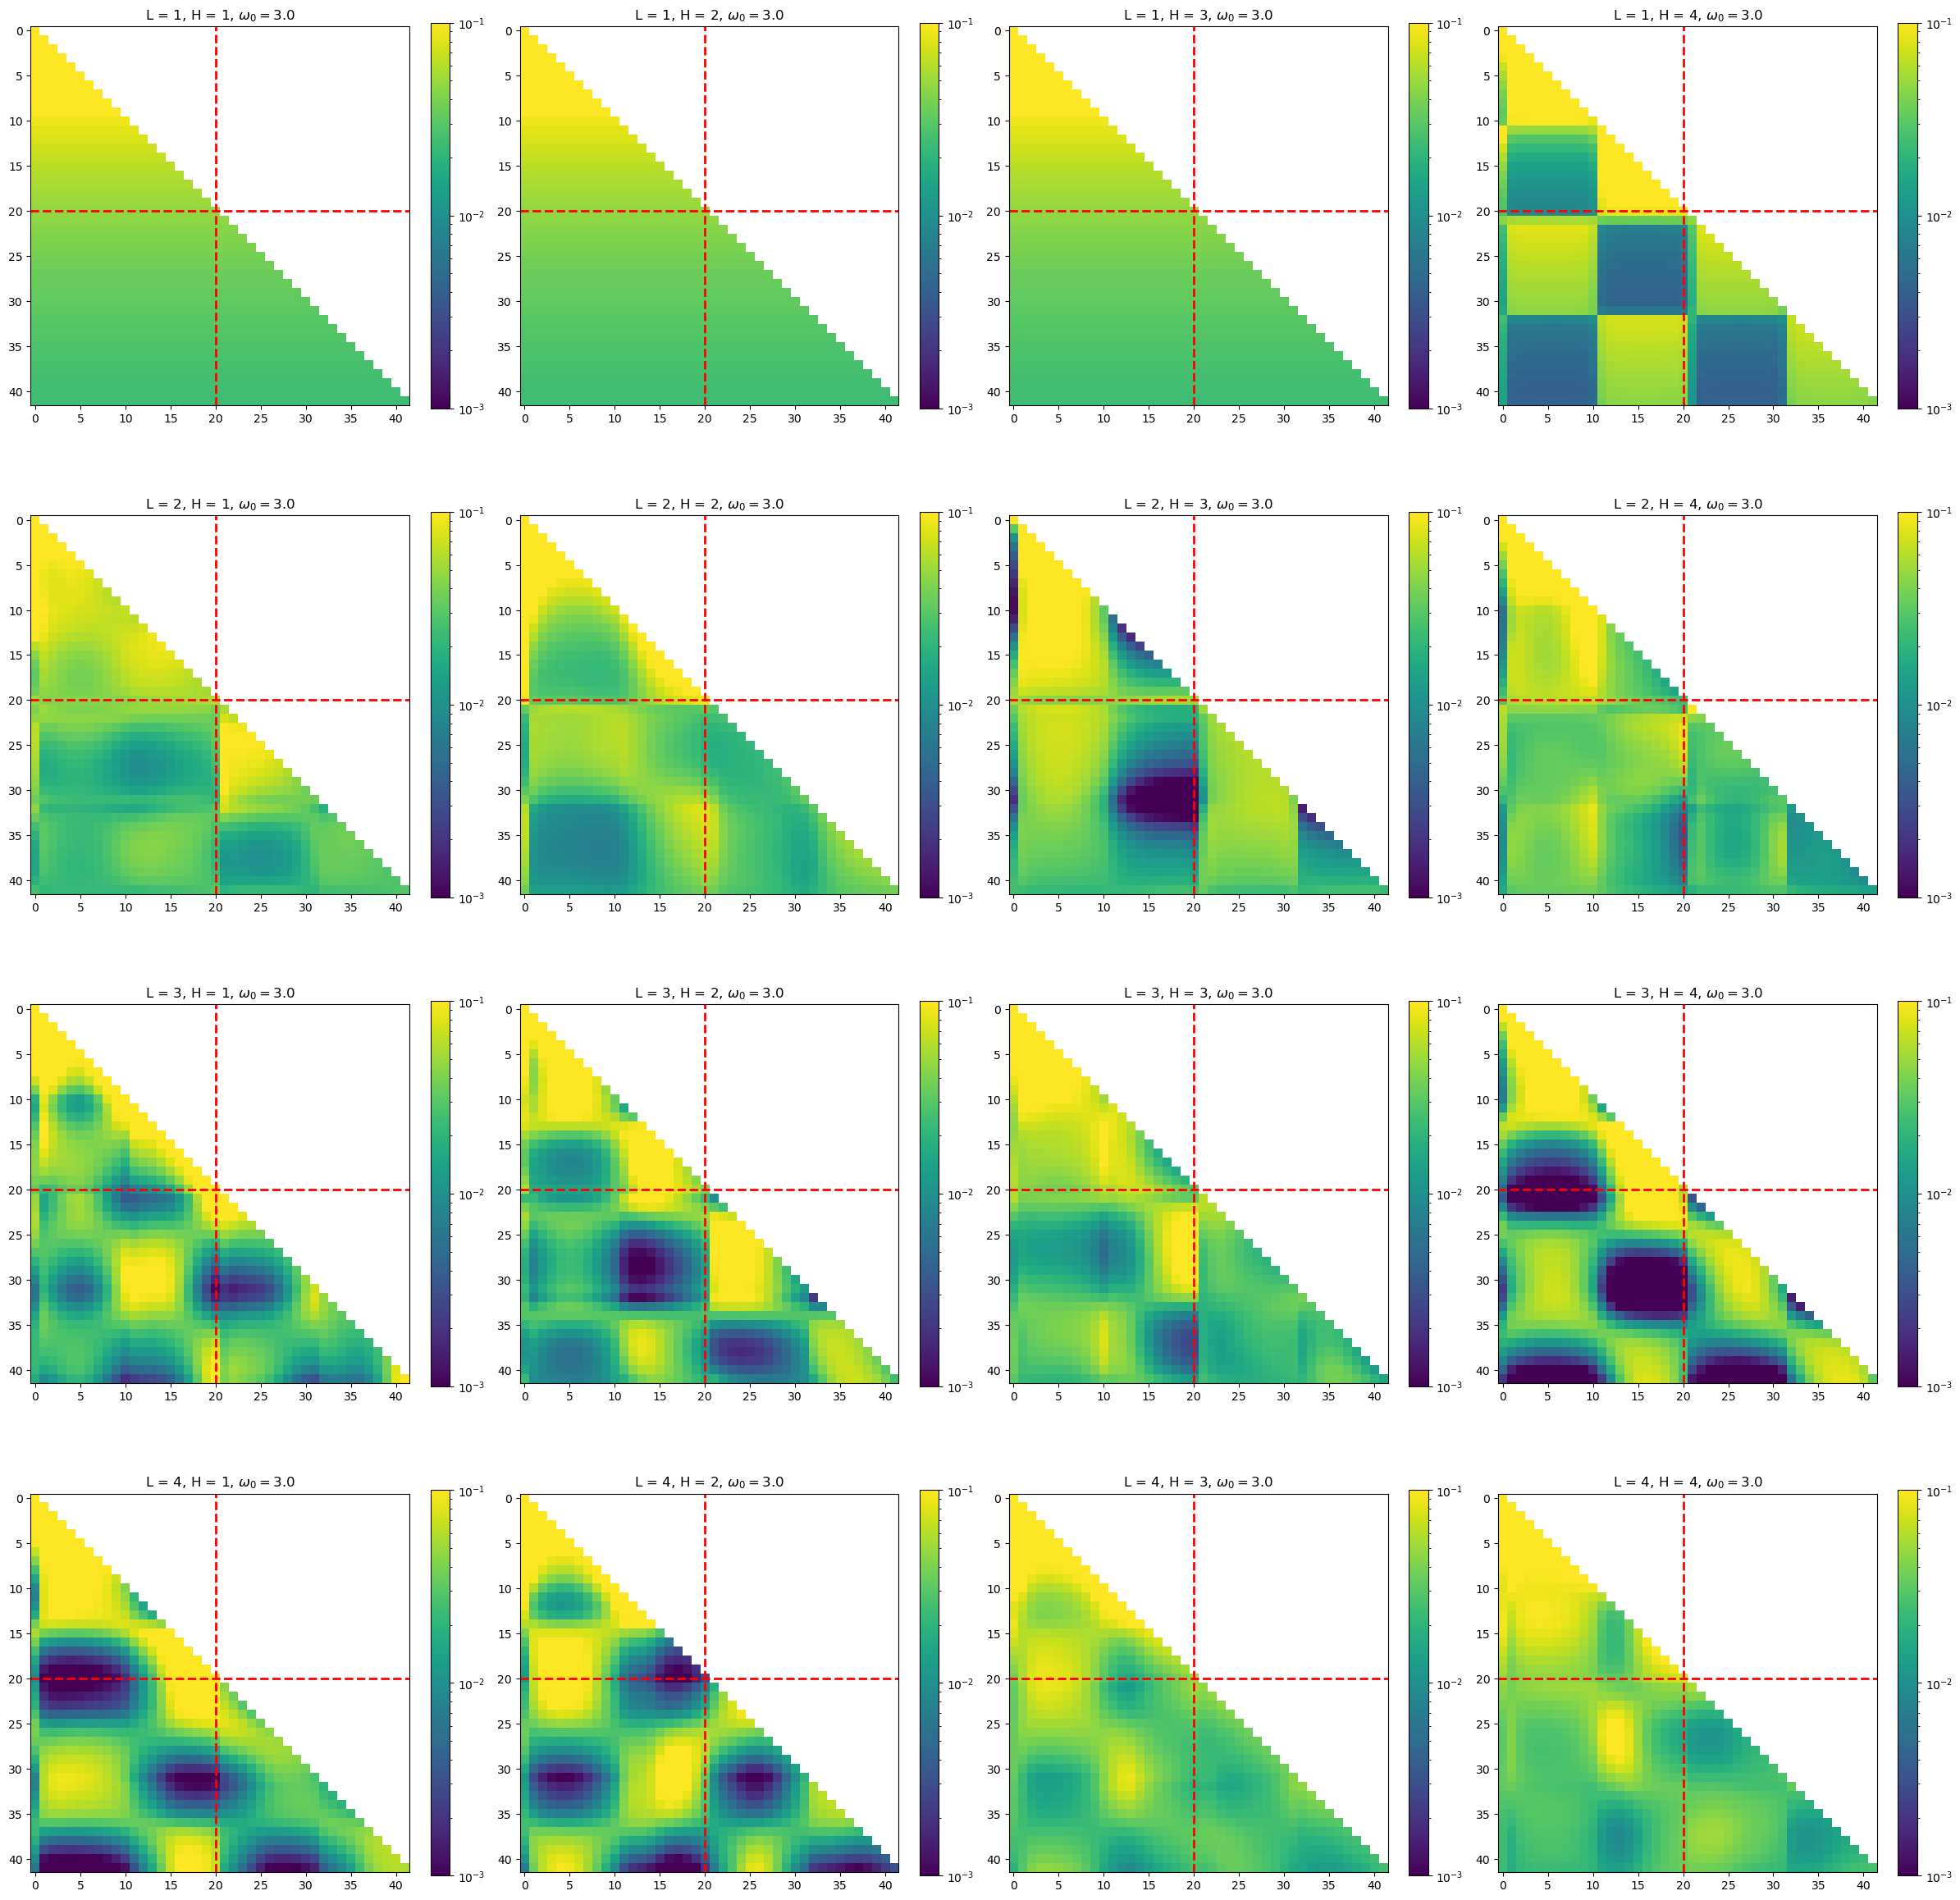

In [154]:
# pin amplitude to 1

num_per = 1
inpt = []
target = []
x0 = 0
v0 = 1
seq_len_test = 250
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,x0=x0,v0=v0,dt=dt,seq_len=seq_len_test,pin_amplitude=1)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

test_i = inpt.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
test_o = target.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

for wsel in [1.0,3.0]:
    for ckpt in iter_ckpts[-1:]:
        #wsel = 5
        iw = list(np.round(w0s,1)).index(wsel)
        i = test_i[iw]
        t = test_o[iw]
        
        with torch.no_grad():
            att = iter_models[ckpt](torch.tensor(i),return_attn=True)
            att = [a.numpy() for a in att]
        
        p = preds[iw,0,:,0]
        T = (2*np.pi/wsel)/dt
        time = np.arange(seq_len_test)
        
        n_head = att[0].shape[1]
        n_lay = len(att)
        fig,axes = plt.subplots(n_lay,n_head,figsize=(6*n_head,6*n_lay))
        for i in range(n_lay):
            for j in range(n_head):
                if n_head == 1:
                    ax = axes[i]
                elif n_lay == 1:
                    ax = axes[j]
                else:
                    ax = axes[i,j]
                plt.sca(ax)
                im=ax.imshow(att[i][0,j,:int(np.ceil(2*T)),:int(np.ceil(2*T))],norm=LogNorm(vmin=1e-3,vmax=0.1))
                for k in range(1,2):
                    plt.axhline(int(k*T),lw=2,linestyle='--',color='red')
                    plt.axvline(int(k*T),lw=2,linestyle='--',color='red')
                plt.colorbar(im,ax=ax,fraction=0.046)
                plt.title(rf"L = {i+1}, H = {j+1}, $\omega_0 = {wsel:.1f}$")
        plt.tight_layout()
        
        #outdir = f"{plot_dir}/attn_maps/w{wsel}/"
        #os.makedirs(outdir,exist_ok=True)
        #plt.savefig(f"{outdir}/maps_w{wsel}_iter{ckpt}.pdf")
        #plt.close()

## forecasting 

In [151]:
num_per = 1
seq_len_fcst = 151
inpt = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,x0=0,v0=1,w0=w0,dt=dt,seq_len=seq_len_fcst)
    i,t = dset.sample(num_per)
    inpt.append(i)
inpt = torch.cat(inpt,dim=0)

max_ctx_forecast = 100
forecast_horizon = 50
fcst_losses = np.zeros((len(w0s),max_ctx_forecast,forecast_horizon))
forecasts = np.zeros((len(w0s),max_ctx_forecast,max_ctx_forecast+forecast_horizon)) 
for n in tqdm(range(1,max_ctx_forecast+1)):
    with torch.no_grad():
        forecast = utils.forecast(iter_models[iter_ckpts[-1]],inpt,forecast_horizon,n)
        error = torch.sum((forecast - inpt[:,:n+forecast_horizon,:])**2,dim=-1)[:,n:]
        fcst_losses[:,n-1,:] = error

        forecast = forecast[:,:,0].numpy()
        forecasts[:,n-1,:forecast.shape[1]] = forecast

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


In [152]:
for iw, wsel in enumerate(w0s):
    outdir = f"{plot_dir}/forecasts/w{wsel:.1f}/"
    os.makedirs(outdir,exist_ok=True)

    for n_ctx in tqdm(range(1,max_ctx_forecast+1)):
        fcast = forecasts[iw,n_ctx-1,:n_ctx+forecast_horizon]
        
        plt.figure(figsize=(8,6))
        isel = inpt[iw][:,0]
        time = np.arange(len(isel))
        time2 = np.arange(len(fcast))
        plt.plot(time,isel)
        plt.plot(time2,fcast)
        
        plt.scatter([time[n_ctx-1]],[isel[n_ctx-1]],marker=".",color='red',s=200)
        
        plt.xlim([0,150])
        plt.title(rf"$\omega_0 = {wsel:.1f}$, {forecast_horizon}-step forecast, {n_ctx} context",fontsize=20)
        plt.tight_layout()
        plt.savefig(f"{outdir}/w{wsel:.1f}_forecast{forecast_horizon}_ctx{n_ctx}.pdf")
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.88it/s]


In [153]:
for iw, wsel in tqdm(enumerate(w0s)):
    outdir = f"{plot_dir}/forecasts/w{wsel:.1f}/"
    os.makedirs(outdir,exist_ok=True)

    fig,ax = plt.subplots(figsize=(8,6))

    n_ctx = 50
    fcast = forecasts[iw,n_ctx-1,:n_ctx+forecast_horizon]
    isel = inpt[iw][:,0]
    time = np.arange(len(isel))
    time2 = np.arange(len(fcast))
    plt.plot(time,isel)
    lfcst, = plt.plot(time2,fcast)
    
    sc = plt.scatter([time[n_ctx-1]],[isel[n_ctx-1]],marker=".",color='red',s=200)
    
    plt.xlim([0,150])
    plt.title(rf"$\omega_0 = {wsel:.1f}$, {forecast_horizon}-step forecast, {n_ctx} context",fontsize=20)
    plt.tight_layout()

    def update(frame):
        fcast = forecasts[iw,frame,:frame+1+forecast_horizon]
        time2 = np.arange(len(fcast))
        lfcst.set_data(time2,fcast)
        sc.set_offsets([[time[frame], isel[frame]]]) 
        ax.set_title(rf"$\omega_0 = {wsel:.1f}$, {forecast_horizon}-step forecast, {frame+1} context",fontsize=20)
        return lines
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=np.arange(max_ctx_forecast), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{outdir}/w{wsel:.1f}_forecast{forecast_horizon}_animation.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

60it [03:13,  3.22s/it]


# further: high --> low

In [98]:
model = "mse_continuousW0Beta_wHi_beta0"
date = "28Jan25_2108"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir, version=date)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']

plot_dir = f"plots/{model}_{date}"
os.makedirs(plot_dir,exist_ok=True)
os.makedirs(f"{plot_dir}/waveforms/",exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
mask_id = (w0s<=2.0)
mask_ood = (w0s>2.0)

In [99]:
num_per = 1
inpt = []
target = []
x0 = 0
v0 = 1
seq_len_test = 200
dtfrac_w1 = dt/(2*np.pi/1.0)
for w0 in w0s:
    T = 2*np.pi/w0
    dt_sel = dtfrac_w1*T
    dset = DampedSHODatasetV2(beta=0,w0=w0,x0=x0,v0=v0,dt=dt,seq_len=seq_len_test)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

test_i = inpt.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
test_o = target.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

with torch.no_grad():
    preds = iter_models[iter_ckpts[-1]](inpt)
    losses = torch.sum((preds-target)**2,dim=-1).numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
    preds = preds.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

In [100]:
for iw,wsel in enumerate(w0s):

    i = test_i[iw,0,:,0]
    t = test_o[iw,0,:,0]
    p = preds[iw,0,:,0]
    T = (2*np.pi/wsel)/dt
    time = np.arange(seq_len_test)
    
    fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True,height_ratios=[3,1])
    plt.sca(axes[0])
    plt.plot(time[:-1],i,label='True')
    plt.plot(time[1:],p,label="Pred (1 step)")
    plt.xlim([0,100])
    plt.title(rf"$\omega_0 = {wsel:.1f}$ (train $\omega_0 \in [0.1,2]$)",fontsize=20)
    plt.sca(axes[1])
    plt.plot(time[1:-1],(i[1:]-p[:-1])**2,color='k')
    plt.yscale('log')
    plt.ylim([1e-6,1e-1])
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/waveforms/waveform_w{wsel:.1f}.pdf")
    plt.close()

In [60]:
def get_mse(wsel,acc=2):
    iw = list(np.round(w0s,acc)).index(np.round(wsel,acc))
    i = test_i[iw,0,:,0]
    p = preds[iw,0,:,0]
    return (i[1:]-p[:-1])**2

## attn maps

In [101]:
num_per = 1
inpt = []
target = []
x0 = 0
v0 = 1
seq_len_test = 250
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,x0=x0,v0=v0,dt=dt,seq_len=seq_len_test)
    i,t = dset.sample(num_per)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

test_i = inpt.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)
test_o = target.numpy().reshape(len(w0s),num_per,seq_len_test-1,-1)

for wsel in [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for ckpt in iter_ckpts:
        #wsel = 5
        iw = list(np.round(w0s,1)).index(wsel)
        i = test_i[iw]
        t = test_o[iw]
        
        with torch.no_grad():
            att = iter_models[ckpt](torch.tensor(i),return_attn=True)
            att = [a.numpy() for a in att]
        
        p = preds[iw,0,:,0]
        T = (2*np.pi/wsel)/dt
        time = np.arange(seq_len_test)
        
        n_head = att[0].shape[1]
        n_lay = len(att)
        fig,axes = plt.subplots(n_lay,n_head,figsize=(6*n_head,6*n_lay))
        for i in range(n_lay):
            for j in range(n_head):
                if n_head == 1:
                    ax = axes[i]
                elif n_lay == 1:
                    ax = axes[j]
                else:
                    ax = axes[i,j]
                plt.sca(ax)
                im=ax.imshow(att[i][0,j,:int(np.ceil(2*T)),:int(np.ceil(2*T))],norm=LogNorm(vmin=1e-3,vmax=0.1))
                for k in range(1,2):
                    plt.axhline(int(k*T),lw=2,linestyle='--',color='red')
                    plt.axvline(int(k*T),lw=2,linestyle='--',color='red')
                plt.colorbar(im,ax=ax,fraction=0.046)
                plt.title(rf"L = {i+1}, H = {j+1}, $\omega_0 = {wsel:.1f}$")
        plt.tight_layout()
        
        outdir = f"{plot_dir}/attn_maps/w{wsel}/"
        os.makedirs(outdir,exist_ok=True)
        plt.savefig(f"{outdir}/maps_w{wsel}_iter{ckpt}.pdf")
        plt.close()

## forecasting 

In [102]:
num_per = 1
seq_len_fcst = 151
inpt = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,x0=0,v0=1,w0=w0,dt=dt,seq_len=seq_len_fcst)
    i,t = dset.sample(num_per)
    inpt.append(i)
inpt = torch.cat(inpt,dim=0)

max_ctx_forecast = 100
forecast_horizon = 50
fcst_losses = np.zeros((len(w0s),max_ctx_forecast,forecast_horizon))
forecasts = np.zeros((len(w0s),max_ctx_forecast,max_ctx_forecast+forecast_horizon)) 
for n in tqdm(range(1,max_ctx_forecast+1)):
    with torch.no_grad():
        forecast = utils.forecast(iter_models[iter_ckpts[-1]],inpt,forecast_horizon,n)
        error = torch.sum((forecast - inpt[:,:n+forecast_horizon,:])**2,dim=-1)[:,n:]
        fcst_losses[:,n-1,:] = error

        forecast = forecast[:,:,0].numpy()
        forecasts[:,n-1,:forecast.shape[1]] = forecast

100%|███████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]


In [103]:
for iw, wsel in enumerate(w0s):
    outdir = f"{plot_dir}/forecasts/w{wsel:.1f}/"
    os.makedirs(outdir,exist_ok=True)

    for n_ctx in tqdm(range(1,max_ctx_forecast+1)):
        fcast = forecasts[iw,n_ctx-1,:n_ctx+forecast_horizon]
        
        plt.figure(figsize=(8,6))
        isel = inpt[iw][:,0]
        time = np.arange(len(isel))
        time2 = np.arange(len(fcast))
        plt.plot(time,isel)
        plt.plot(time2,fcast)
        
        plt.scatter([time[n_ctx-1]],[isel[n_ctx-1]],marker=".",color='red',s=200)
        
        plt.xlim([0,150])
        plt.title(rf"$\omega_0 = {wsel:.1f}$, {forecast_horizon}-step forecast, {n_ctx} context",fontsize=20)
        plt.tight_layout()
        plt.savefig(f"{outdir}/w{wsel:.1f}_forecast{forecast_horizon}_ctx{n_ctx}.pdf")
        plt.close()

100%|███████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.15it/s]


In [104]:
for iw, wsel in tqdm(enumerate(w0s)):
    outdir = f"{plot_dir}/forecasts/w{wsel:.1f}/"
    os.makedirs(outdir,exist_ok=True)

    fig,ax = plt.subplots(figsize=(8,6))

    n_ctx = 50
    fcast = forecasts[iw,n_ctx-1,:n_ctx+forecast_horizon]
    isel = inpt[iw][:,0]
    time = np.arange(len(isel))
    time2 = np.arange(len(fcast))
    plt.plot(time,isel)
    lfcst, = plt.plot(time2,fcast)
    
    sc = plt.scatter([time[n_ctx-1]],[isel[n_ctx-1]],marker=".",color='red',s=200)
    
    plt.xlim([0,150])
    plt.title(rf"$\omega_0 = {wsel:.1f}$, {forecast_horizon}-step forecast, {n_ctx} context",fontsize=20)
    plt.tight_layout()

    def update(frame):
        fcast = forecasts[iw,frame,:frame+1+forecast_horizon]
        time2 = np.arange(len(fcast))
        lfcst.set_data(time2,fcast)
        sc.set_offsets([[time[frame], isel[frame]]]) 
        ax.set_title(rf"$\omega_0 = {wsel:.1f}$, {forecast_horizon}-step forecast, {frame+1} context",fontsize=20)
        return lines
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=np.arange(max_ctx_forecast), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{outdir}/w{wsel:.1f}_forecast{forecast_horizon}_animation.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

60it [03:16,  3.27s/it]
